# KAN + SupCon + CenterLoss + Differentiable KShape on Trace Dataset

In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy.optimize import linear_sum_assignment


In [2]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# 加载 ETTh1 数据
df = pd.read_csv("ETTh1.csv")
df = df.drop(columns=["date"])
X_raw = df.values
X_raw = StandardScaler().fit_transform(X_raw)

# 滑窗提取样本（每96小时为一个样本）
window_size = 96
X = [X_raw[i:i+window_size].flatten() for i in range(0, len(X_raw)-window_size, window_size)]
X = np.stack(X)

# 构造伪标签，用于监督聚类指标计算（如ACC、NMI等）
k = 4  # 设置聚类类别数
samples_per_cluster = len(X) // k
y = np.concatenate([[i] * samples_per_cluster for i in range(k)])
y = np.pad(y, (0, len(X) - len(y)), constant_values=k - 1)
num_classes = len(np.unique(y))


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

sys.path.insert(0, './pykan_local/kan')  # 加入你本地pykan目录

from KANLayer_local import KANLayer # 来自你 pykan 文件夹

class KANEncoder(nn.Module):
    def __init__(self, input_dim=275, hidden_dim=128, output_dim=128):
        super().__init__()
        self.layer1 = KANLayer(in_dim=input_dim, out_dim=hidden_dim, num=21)
        self.layer2 = KANLayer(in_dim=hidden_dim, out_dim=hidden_dim, num=21)
        self.layer3 = KANLayer(in_dim=hidden_dim, out_dim=output_dim, num=21)

    def forward(self, x):
        x, _, _, _ = self.layer1(x)
        x, _, _, _ = self.layer2(x)
        x, _, _, _ = self.layer3(x)
        return F.normalize(x, dim=-1)

In [4]:

class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim):
        super().__init__()
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, x, labels):
        return ((x - self.centers[labels])**2).sum() / 2.0

class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        features = F.normalize(features, dim=1)
        sim_matrix = torch.matmul(features, features.T) / self.temperature
        mask = torch.eq(labels.unsqueeze(1), labels.unsqueeze(0)).float().to(device)
        logits_mask = torch.ones_like(mask) - torch.eye(features.shape[0], device=device)
        exp_sim = torch.exp(sim_matrix) * logits_mask
        log_prob = sim_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True) + 1e-9)
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1).clamp(min=1)
        return -mean_log_prob_pos.mean()

def differentiable_kshape_loss(features, labels, num_classes):
    loss = 0
    for c in range(num_classes):
        mask = labels == c
        if mask.sum() < 2:
            continue
        cluster_feat = features[mask]
        prototype = cluster_feat.mean(dim=0)
        aligned = F.cosine_similarity(cluster_feat, prototype.unsqueeze(0))
        loss += (1 - aligned).mean()
    return loss


In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

encoder = KANEncoder(input_dim=X.shape[1], output_dim=128)
center_loss_fn = CenterLoss(num_classes=num_classes, feat_dim=128)
supcon_loss_fn = SupConLoss()
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)

epochs = 80
epochs = 80
loss_history = []
ari_history = []
nmi_history = []

for epoch in tqdm(range(epochs)):
    encoder.train()
    total_loss = 0

    for xb, yb in loader:
        optimizer.zero_grad()
        feats = encoder(xb)
        loss = (center_loss_fn(feats, yb) +
                supcon_loss_fn(feats, yb) +
                differentiable_kshape_loss(feats, yb, num_classes))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss_history.append(total_loss)

   # ===== ✅ 聚类评估指标 =====
    encoder.eval()
    with torch.no_grad():
        feats_all = encoder(X_tensor).cpu().numpy()
        true_labels = y_tensor.cpu().numpy()

    kmeans = KMeans(n_clusters=num_classes, n_init=20, random_state=42)
    pred_labels = kmeans.fit_predict(feats_all)

    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    sil = silhouette_score(feats_all, pred_labels)

    ari_history.append(ari)
    nmi_history.append(nmi)

    print(f"Epoch {epoch} | Loss: {total_loss:.4f} | ARI: {ari:.4f} | NMI: {nmi:.4f} | Silhouette: {sil:.4f}")

/root/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  1%|▏         | 1/80 [00:02<02:44,  2.08s/it]

Epoch 0 | Loss: 9998.0999 | ARI: 0.4524 | NMI: 0.4891 | Silhouette: 0.3288


  2%|▎         | 2/80 [00:02<01:48,  1.39s/it]

Epoch 1 | Loss: 9425.5706 | ARI: 0.6033 | NMI: 0.6541 | Silhouette: 0.4632


  4%|▍         | 3/80 [00:03<01:30,  1.17s/it]

Epoch 2 | Loss: 9241.6670 | ARI: 0.7196 | NMI: 0.7683 | Silhouette: 0.5625


  5%|▌         | 4/80 [00:04<01:20,  1.06s/it]

Epoch 3 | Loss: 9109.8744 | ARI: 0.9020 | NMI: 0.9086 | Silhouette: 0.6189


  6%|▋         | 5/80 [00:05<01:18,  1.04s/it]

Epoch 4 | Loss: 9019.5778 | ARI: 0.9704 | NMI: 0.9616 | Silhouette: 0.7418


  8%|▊         | 6/80 [00:06<01:13,  1.01it/s]

Epoch 5 | Loss: 8948.6094 | ARI: 0.9851 | NMI: 0.9808 | Silhouette: 0.8181


  9%|▉         | 7/80 [00:07<01:12,  1.01it/s]

Epoch 6 | Loss: 8921.0590 | ARI: 0.9851 | NMI: 0.9808 | Silhouette: 0.8667


 10%|█         | 8/80 [00:08<01:13,  1.03s/it]

Epoch 7 | Loss: 8904.4734 | ARI: 0.9851 | NMI: 0.9808 | Silhouette: 0.8925


 11%|█▏        | 9/80 [00:09<01:12,  1.01s/it]

Epoch 8 | Loss: 8894.0233 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9097


 12%|█▎        | 10/80 [00:10<01:08,  1.02it/s]

Epoch 9 | Loss: 8889.2808 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9257


 14%|█▍        | 11/80 [00:11<01:06,  1.04it/s]

Epoch 10 | Loss: 8886.1915 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9374


 15%|█▌        | 12/80 [00:12<01:06,  1.03it/s]

Epoch 11 | Loss: 8883.9194 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9447


 16%|█▋        | 13/80 [00:13<01:05,  1.02it/s]

Epoch 12 | Loss: 8883.0388 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9519


 18%|█▊        | 14/80 [00:14<01:03,  1.04it/s]

Epoch 13 | Loss: 8882.3700 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9570


 19%|█▉        | 15/80 [00:15<01:03,  1.03it/s]

Epoch 14 | Loss: 8881.7335 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9609


 20%|██        | 16/80 [00:16<01:06,  1.04s/it]

Epoch 15 | Loss: 8881.3853 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9643


 21%|██▏       | 17/80 [00:17<01:04,  1.02s/it]

Epoch 16 | Loss: 8881.2130 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9670


 22%|██▎       | 18/80 [00:18<00:59,  1.04it/s]

Epoch 17 | Loss: 8880.9455 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9692


 24%|██▍       | 19/80 [00:19<00:59,  1.03it/s]

Epoch 18 | Loss: 8880.8081 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9712


 25%|██▌       | 20/80 [00:20<00:56,  1.05it/s]

Epoch 19 | Loss: 8880.3691 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9729


 26%|██▋       | 21/80 [00:21<00:56,  1.04it/s]

Epoch 20 | Loss: 8880.8566 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9744


 28%|██▊       | 22/80 [00:22<00:56,  1.02it/s]

Epoch 21 | Loss: 8880.5262 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9758


 29%|██▉       | 23/80 [00:23<00:54,  1.05it/s]

Epoch 22 | Loss: 8880.5051 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9770


 30%|███       | 24/80 [00:24<00:50,  1.10it/s]

Epoch 23 | Loss: 8880.4913 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9781


 31%|███▏      | 25/80 [00:25<00:51,  1.08it/s]

Epoch 24 | Loss: 8880.3818 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9791


 32%|███▎      | 26/80 [00:26<00:51,  1.05it/s]

Epoch 25 | Loss: 8880.3938 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9801


 34%|███▍      | 27/80 [00:27<00:51,  1.03it/s]

Epoch 26 | Loss: 8880.2643 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9810


 35%|███▌      | 28/80 [00:28<00:49,  1.05it/s]

Epoch 27 | Loss: 8880.2843 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9818


 36%|███▋      | 29/80 [00:28<00:47,  1.07it/s]

Epoch 28 | Loss: 8880.2727 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9825


 38%|███▊      | 30/80 [00:29<00:47,  1.05it/s]

Epoch 29 | Loss: 8880.5474 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9832


 39%|███▉      | 31/80 [00:30<00:45,  1.07it/s]

Epoch 30 | Loss: 8879.9747 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9839


 40%|████      | 32/80 [00:31<00:44,  1.08it/s]

Epoch 31 | Loss: 8880.2122 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9845


 41%|████▏     | 33/80 [00:32<00:44,  1.06it/s]

Epoch 32 | Loss: 8880.3995 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9850


 42%|████▎     | 34/80 [00:33<00:42,  1.07it/s]

Epoch 33 | Loss: 8880.1774 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9856


 44%|████▍     | 35/80 [00:34<00:44,  1.01it/s]

Epoch 34 | Loss: 8880.0765 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9861


 45%|████▌     | 36/80 [00:35<00:42,  1.04it/s]

Epoch 35 | Loss: 8880.0738 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9866


 46%|████▋     | 37/80 [00:36<00:41,  1.03it/s]

Epoch 36 | Loss: 8880.1085 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9870


 48%|████▊     | 38/80 [00:37<00:42,  1.01s/it]

Epoch 37 | Loss: 8880.1794 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9874


 49%|████▉     | 39/80 [00:38<00:40,  1.02it/s]

Epoch 38 | Loss: 8880.1124 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9879


 50%|█████     | 40/80 [00:39<00:38,  1.05it/s]

Epoch 39 | Loss: 8880.1029 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9882


 51%|█████▏    | 41/80 [00:40<00:38,  1.00it/s]

Epoch 40 | Loss: 8880.1025 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9886


 52%|█████▎    | 42/80 [00:41<00:36,  1.04it/s]

Epoch 41 | Loss: 8880.3354 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9890


 54%|█████▍    | 43/80 [00:42<00:36,  1.02it/s]

Epoch 42 | Loss: 8880.0485 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9893


 55%|█████▌    | 44/80 [00:43<00:33,  1.08it/s]

Epoch 43 | Loss: 8880.1212 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9896


 56%|█████▋    | 45/80 [00:44<00:33,  1.06it/s]

Epoch 44 | Loss: 8880.0067 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9899


 57%|█████▊    | 46/80 [00:45<00:31,  1.07it/s]

Epoch 45 | Loss: 8880.2678 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9902


 59%|█████▉    | 47/80 [00:46<00:30,  1.08it/s]

Epoch 46 | Loss: 8880.1328 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9905


 60%|██████    | 48/80 [00:47<00:29,  1.09it/s]

Epoch 47 | Loss: 8880.1986 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9907


 61%|██████▏   | 49/80 [00:47<00:29,  1.06it/s]

Epoch 48 | Loss: 8880.0629 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9910


 62%|██████▎   | 50/80 [00:49<00:29,  1.02it/s]

Epoch 49 | Loss: 8880.1193 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9912


 64%|██████▍   | 51/80 [00:49<00:27,  1.07it/s]

Epoch 50 | Loss: 8880.0660 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9914


 65%|██████▌   | 52/80 [00:50<00:25,  1.08it/s]

Epoch 51 | Loss: 8880.0557 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9917


 66%|██████▋   | 53/80 [00:51<00:24,  1.09it/s]

Epoch 52 | Loss: 8880.0907 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9919


 68%|██████▊   | 54/80 [00:52<00:23,  1.10it/s]

Epoch 53 | Loss: 8879.9535 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9921


 69%|██████▉   | 55/80 [00:53<00:23,  1.06it/s]

Epoch 54 | Loss: 8879.7545 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9923


 70%|███████   | 56/80 [00:54<00:22,  1.08it/s]

Epoch 55 | Loss: 8879.6799 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9924


 71%|███████▏  | 57/80 [00:55<00:22,  1.03it/s]

Epoch 56 | Loss: 8880.1458 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9925


 72%|███████▎  | 58/80 [00:56<00:20,  1.05it/s]

Epoch 57 | Loss: 8879.9427 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9927


 74%|███████▍  | 59/80 [00:57<00:20,  1.04it/s]

Epoch 58 | Loss: 8880.1058 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9929


 75%|███████▌  | 60/80 [00:58<00:18,  1.09it/s]

Epoch 59 | Loss: 8880.0251 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9931


 76%|███████▋  | 61/80 [00:59<00:17,  1.09it/s]

Epoch 60 | Loss: 8879.9744 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9932


 78%|███████▊  | 62/80 [01:00<00:16,  1.07it/s]

Epoch 61 | Loss: 8880.1327 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9934


 79%|███████▉  | 63/80 [01:01<00:15,  1.08it/s]

Epoch 62 | Loss: 8879.9890 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9936


 80%|████████  | 64/80 [01:02<00:14,  1.08it/s]

Epoch 63 | Loss: 8879.9725 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9937


 81%|████████▏ | 65/80 [01:02<00:14,  1.06it/s]

Epoch 64 | Loss: 8879.9624 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9938


 82%|████████▎ | 66/80 [01:04<00:13,  1.01it/s]

Epoch 65 | Loss: 8879.9520 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9940


 84%|████████▍ | 67/80 [01:04<00:12,  1.07it/s]

Epoch 66 | Loss: 8880.2054 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9941


 85%|████████▌ | 68/80 [01:05<00:11,  1.05it/s]

Epoch 67 | Loss: 8880.0757 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9942


 86%|████████▋ | 69/80 [01:06<00:10,  1.06it/s]

Epoch 68 | Loss: 8879.8434 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9944


 88%|████████▊ | 70/80 [01:07<00:09,  1.04it/s]

Epoch 69 | Loss: 8880.0347 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9945


 89%|████████▉ | 71/80 [01:08<00:08,  1.03it/s]

Epoch 70 | Loss: 8879.9207 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9946


 90%|█████████ | 72/80 [01:09<00:07,  1.05it/s]

Epoch 71 | Loss: 8880.1223 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9947


 91%|█████████▏| 73/80 [01:10<00:06,  1.04it/s]

Epoch 72 | Loss: 8880.0034 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9948


 92%|█████████▎| 74/80 [01:11<00:05,  1.05it/s]

Epoch 73 | Loss: 8879.9666 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9949


 94%|█████████▍| 75/80 [01:12<00:04,  1.05it/s]

Epoch 74 | Loss: 8880.1531 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9950


 95%|█████████▌| 76/80 [01:13<00:03,  1.09it/s]

Epoch 75 | Loss: 8879.9023 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9951


 96%|█████████▋| 77/80 [01:14<00:02,  1.13it/s]

Epoch 76 | Loss: 8879.9907 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9952


 98%|█████████▊| 78/80 [01:15<00:01,  1.09it/s]

Epoch 77 | Loss: 8880.0270 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9953


 99%|█████████▉| 79/80 [01:16<00:00,  1.10it/s]

Epoch 78 | Loss: 8879.5821 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9954


100%|██████████| 80/80 [01:16<00:00,  1.04it/s]

Epoch 79 | Loss: 8880.0720 | ARI: 1.0000 | NMI: 1.0000 | Silhouette: 0.9954


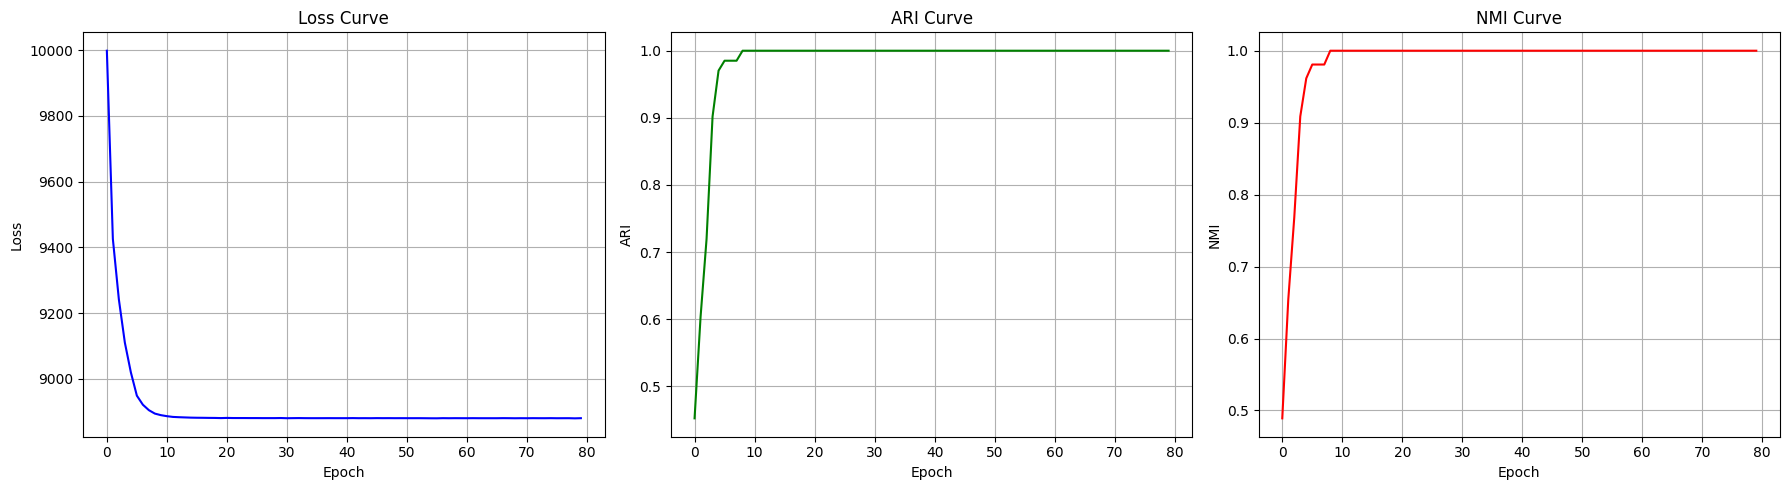

In [6]:
# ===== 📈 可视化 Loss / ARI / NMI 曲线 =====
epochs_range = range(len(loss_history))

# 创建横向排列的三个子图
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

axs[0].plot(epochs_range, loss_history, label='Loss', color='blue')
axs[0].set_title('Loss Curve')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].grid(True)

axs[1].plot(epochs_range, ari_history, label='ARI', color='green')
axs[1].set_title('ARI Curve')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('ARI')
axs[1].grid(True)

axs[2].plot(epochs_range, nmi_history, label='NMI', color='red')
axs[2].set_title('NMI Curve')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('NMI')
axs[2].grid(True)
plt.tight_layout()

svg_path = "./metrics_over_epochs1.svg"
plt.savefig(svg_path, format='svg')
plt.show()

In [7]:

@torch.no_grad()
def evaluate_clustering(encoder, X_tensor, y_true, num_classes):
    encoder.eval()
    feats = encoder(X_tensor).cpu().numpy()
    from sklearn.cluster import KMeans
    km = KMeans(n_clusters=num_classes, random_state=42).fit(feats)
    pred = km.labels_

    # Hungarian matching
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}
    pred_aligned = np.array([mapping[p] for p in pred])

    ari = adjusted_rand_score(y_true, pred_aligned)
    nmi = normalized_mutual_info_score(y_true, pred_aligned)
    sil = silhouette_score(feats, y_true)
    print(f"ARI: {ari:.4f}, NMI: {nmi:.4f}, Silhouette: {sil:.4f}")
    return feats, pred_aligned

feats, pred = evaluate_clustering(encoder, X_tensor, y, num_classes)


ARI: 1.0000, NMI: 1.0000, Silhouette: 0.9954


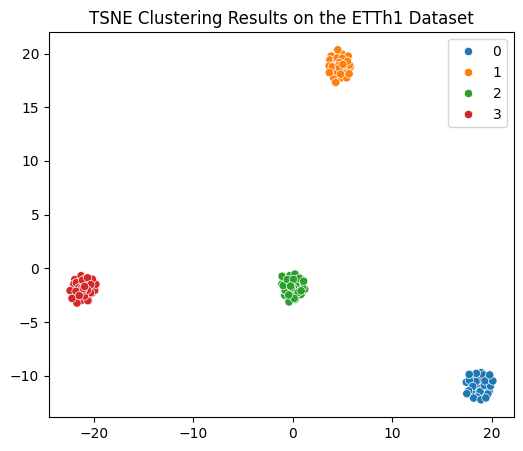

In [8]:

tsne = TSNE(n_components=2)
vis = tsne.fit_transform(feats)
plt.figure(figsize=(6,5))
sns.scatterplot(x=vis[:,0], y=vis[:,1], hue=pred, palette='tab10')
plt.title("TSNE Clustering Results on the ETTh1 Dataset")
plt.show()


In [9]:
from scipy.optimize import linear_sum_assignment
import numpy as np

def clustering_accuracy(true_labels, pred_labels):
    """
    使用匈牙利算法计算聚类准确率 ACC。
    """
    true_labels = np.asarray(true_labels)
    pred_labels = np.asarray(pred_labels)
    assert true_labels.shape == pred_labels.shape

    D = max(pred_labels.max(), true_labels.max()) + 1
    cost_matrix = np.zeros((D, D), dtype=np.int64)

    for i in range(pred_labels.size):
        cost_matrix[pred_labels[i], true_labels[i]] += 1

    row_ind, col_ind = linear_sum_assignment(cost_matrix.max() - cost_matrix)
    acc = cost_matrix[row_ind, col_ind].sum() / pred_labels.size
    return acc

acc = clustering_accuracy(true_labels, pred_labels)
print(f"Clustering Accuracy (ACC): {acc:.4f}")

Clustering Accuracy (ACC): 1.0000


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cluster_lines(X, y_pred, n_clusters, window_size, num_features):
    assert X.shape[1] == window_size * num_features, "X shape不正确，必须是flatten后的时间序列段"

    feature_names = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]

    for cluster_id in range(n_clusters):
        cluster_indices = np.where(y_pred == cluster_id)[0]
        cluster_data = X[cluster_indices]
        cluster_data = cluster_data.reshape(-1, window_size, num_features)
        avg_curve = cluster_data.mean(axis=0)

        plt.figure(figsize=(12, 4))
        for sample in cluster_data:
            for f in range(num_features):
                plt.plot(sample[:, f], color='lightgray', linewidth=0.8, alpha=0.5)
        for f in range(num_features):
            plt.plot(avg_curve[:, f], label=feature_names[f], linewidth=2.5)

        plt.title(f"Cluster {cluster_id}: {len(cluster_indices)} samples")
        plt.xlabel("Time (hour)")
        plt.ylabel("Normalized Value")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"cluster_{cluster_id}.svg", format="svg")
        plt.show()


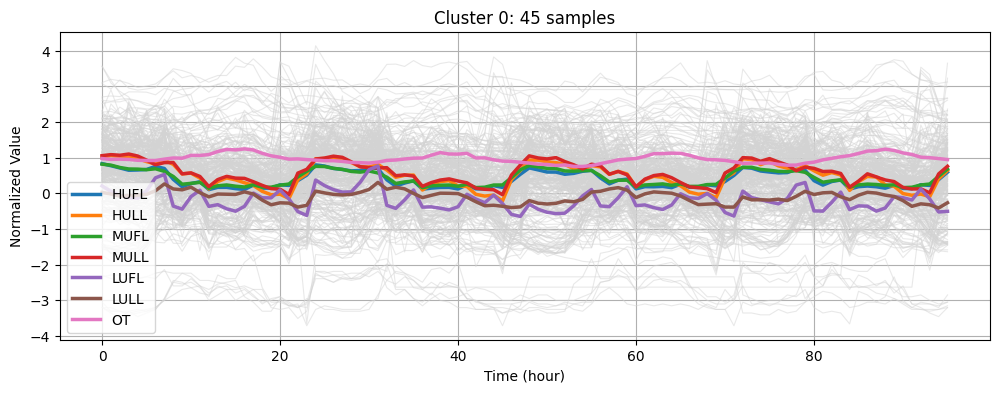

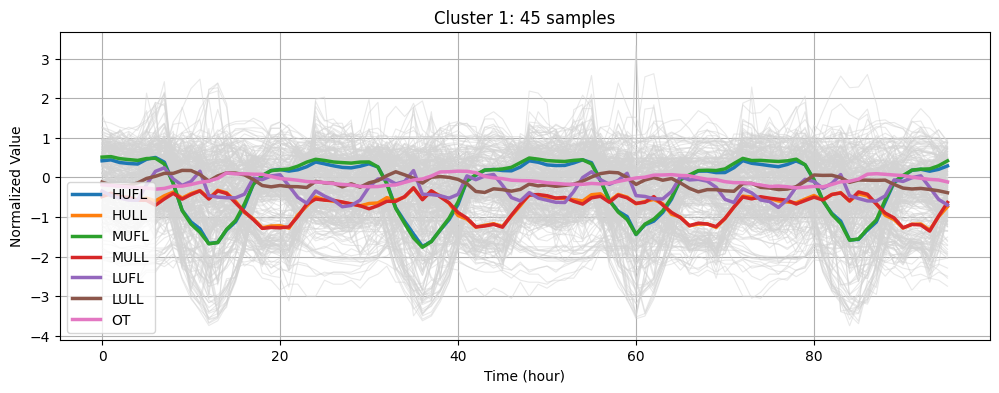

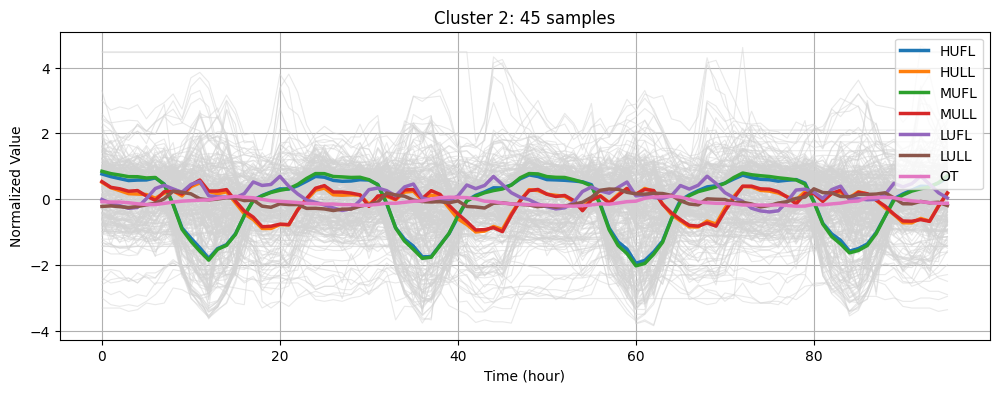

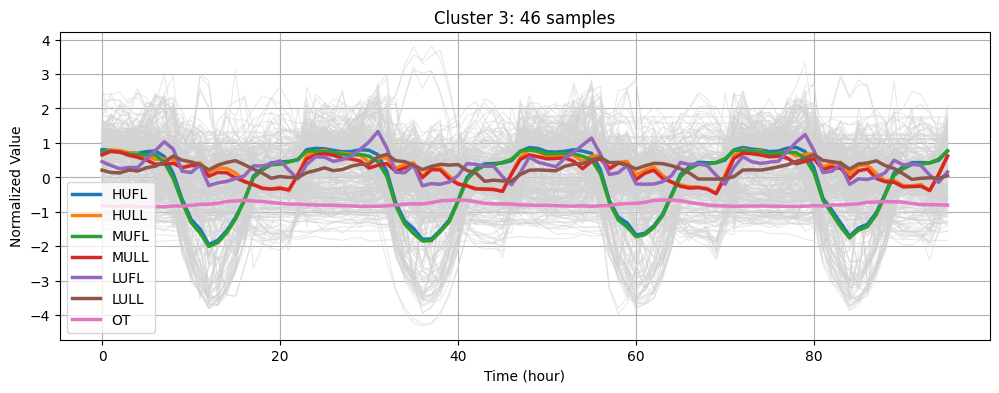

NameError: name 'cluster_id' is not defined

In [11]:
plot_cluster_lines(X, pred, n_clusters=4, window_size=96, num_features=7)
plt.savefig(f"ETTh1figures/cluster_{cluster_id}.svg", format="svg")
